In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torchvision.transforms as transforms


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 데이터프레임 생성

In [2]:
'''import os
import pandas as pd
from sklearn.model_selection import train_test_split

data_dir = "train_data/"

# CSV 파일 경로 리스트 생성
csv_files = [f for f in os.listdir(data_dir) if f.endswith('_image_class_info.csv')]

# 모든 데이터를 담을 리스트
all_data = []

# 각 CSV 파일을 읽어서 데이터를 리스트에 추가
for csv_file in csv_files:
    file_path = os.path.join(data_dir, csv_file)
    df = pd.read_csv(file_path)
    all_data.append(df)

# 모든 데이터를 하나의 DataFrame으로 결합
all_data_df = pd.concat(all_data, ignore_index=True)

# 클래스별로 데이터셋 나누기
train_data = []
val_data = []
test_data = []

# 각 클래스의 고유값을 가져옴
classes = all_data_df['class'].unique()


for class_label in classes:
    class_data = all_data_df[all_data_df['class'] == class_label]
    train_df, temp_df = train_test_split(class_data, test_size=0.5, random_state=25)
    val_df, test_df = train_test_split(temp_df, test_size=0.9, random_state=25)
    train_data.append(train_df)
    val_data.append(val_df)
    test_data.append(test_df)

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True)
test_df = pd.concat(test_data, ignore_index=True)

# 저장 경로
train_csv_path = "train_data/train_image_class_info.csv"
val_csv_path = "train_data/val_image_class_info.csv"
test_csv_path = "train_data/test_image_class_info.csv"

# 데이터프레임을 CSV 파일로 저장
train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"Train, Validation, and Test sets have been saved to {data_dir}.")'''

'import os\nimport pandas as pd\nfrom sklearn.model_selection import train_test_split\n\ndata_dir = "train_data/"\n\n# CSV 파일 경로 리스트 생성\ncsv_files = [f for f in os.listdir(data_dir) if f.endswith(\'_image_class_info.csv\')]\n\n# 모든 데이터를 담을 리스트\nall_data = []\n\n# 각 CSV 파일을 읽어서 데이터를 리스트에 추가\nfor csv_file in csv_files:\n    file_path = os.path.join(data_dir, csv_file)\n    df = pd.read_csv(file_path)\n    all_data.append(df)\n\n# 모든 데이터를 하나의 DataFrame으로 결합\nall_data_df = pd.concat(all_data, ignore_index=True)\n\n# 클래스별로 데이터셋 나누기\ntrain_data = []\nval_data = []\ntest_data = []\n\n# 각 클래스의 고유값을 가져옴\nclasses = all_data_df[\'class\'].unique()\n\n\nfor class_label in classes:\n    class_data = all_data_df[all_data_df[\'class\'] == class_label]\n    train_df, temp_df = train_test_split(class_data, test_size=0.5, random_state=25)\n    val_df, test_df = train_test_split(temp_df, test_size=0.9, random_state=25)\n    train_data.append(train_df)\n    val_data.append(val_df)\n    test_data.append(te

In [5]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

train = pd.read_csv('/media/wkdtjdqls/easymean_1/Protocol_Data/Case_1/TRAIN.csv')
val = pd.read_csv('train_data/val_image_class_info.csv')
test = pd.read_csv('train_data/test_image_class_info.csv')

train_rows = train.shape[0] 
val_rows = val.shape[0]   
test_rows = test.shape[0]   

print(f"Train Data Rows: {train_rows}")
print(f"Validation Data Rows: {val_rows}")
print(f"Test Data Rows: {test_rows}")

FileNotFoundError: [Errno 2] No such file or directory: 'train_data/val_image_class_info.csv'

In [159]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':4,
    'SEED':41,
    'CROP_SIZE':200
}

In [160]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    r"""
    3x3 convolution with padding
    - in_planes: in_channels
    - out_channels: out_channels
    - bias=False: BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정.
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [161]:
class CustomDataset(Dataset):
    def __init__(self, image_path_list, label_list):
        self.image_path_list = image_path_list
        self.label_list = label_list
        
    def __getitem__(self, index):
        
        path = self.image_path_list[index]

        frames = self.get_image(path)
            
        if self.label_list is not None:
            label = self.label_list[index]
            return frames, label
        else:
            return frames
        
    def __len__(self):
        return len(self.image_path_list)
    
    def get_image(self, path):
        # Read image
        img = cv2.imread(path)
        if img is None:
            print(f"Error reading image file {path}")
            return torch.empty(0) 
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ''' height, width = img.shape[:2]
        
        if CFG['CROP_SIZE'] > 0 and (width - CFG['CROP_SIZE'] * 2) > 0:
            img = img[:, CFG['CROP_SIZE']:width - CFG['CROP_SIZE']]
        else:
            print(f"Invalid crop size for image {path}")
            return torch.empty(0)
        img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
        img = img / 255.0  # Normalize to [0, 1]     '''      
            
        return torch.FloatTensor(img).permute(2, 0, 1)

In [162]:
train_dataset = CustomDataset(train['image_path'].values, train['class'].values)
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val['image_path'].values, val['class'].values)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

In [163]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        r"""
         - inplanes: input channel size
         - planes: output channel size
         - groups, base_width: ResNext나 Wide ResNet의 경우 사용
        """
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
            
        # Basic Block의 구조
        self.conv1 = conv3x3(inplanes, planes, stride)  # conv1에서 downsample
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        # short connection
        if self.downsample is not None:
            identity = self.downsample(x)
            
        # identity mapping시 identity mapping후 ReLU를 적용합니다.
        # 그 이유는, ReLU를 통과하면 양의 값만 남기 때문에 Residual의 의미가 제대로 유지되지 않기 때문입니다.
        out += identity
        out = self.relu(out)

        return out

In [164]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4 # 블록 내에서 차원을 증가시키는 3번째 conv layer에서의 확장계수
    
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # ResNext나 WideResNet의 경우 사용
        width = int(planes * (base_width / 64.)) * groups
        
        # Bottleneck Block의 구조
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation) # conv2에서 downsample
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        # 1x1 convolution layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # 3x3 convolution layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # 1x1 convolution layer
        out = self.conv3(out)
        out = self.bn3(out)
        # skip connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [165]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        # default values
        self.inplanes = 64 # input feature map
        self.dilation = 1
        # stride를 dilation으로 대체할지 선택
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        
        r"""
        - 처음 입력에 적용되는 self.conv1과 self.bn1, self.relu는 모든 ResNet에서 동일 
        - 3: 입력으로 RGB 이미지를 사용하기 때문에 convolution layer에 들어오는 input의 channel 수는 3
        """
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        r"""
        - 아래부터 block 형태와 갯수가 ResNet층마다 변화
        - self.layer1 ~ 4: 필터의 개수는 각 block들을 거치면서 증가(64->128->256->512)
        - self.avgpool: 모든 block을 거친 후에는 Adaptive AvgPool2d를 적용하여 (n, 512, 1, 1)의 텐서로
        - self.fc: 이후 fc layer를 연결
        """
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, # 여기서부터 downsampling적용
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        r"""
        convolution layer 생성 함수
        - block: block종류 지정
        - planes: feature map size (input shape)
        - blocks: layers[0]와 같이, 해당 블록이 몇개 생성돼야하는지, 블록의 갯수 (layer 반복해서 쌓는 개수)
        - stride와 dilate은 고정
        """
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        
        # the number of filters is doubled: self.inplanes와 planes 사이즈를 맞춰주기 위한 projection shortcut
        # the feature map size is halved: stride=2로 downsampling
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        # 블록 내 시작 layer, downsampling 필요
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion # inplanes 업데이트
        # 동일 블록 반복
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [166]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = F.cross_entropy
    
    train_losses = []
    val_losses = []
    val_scores = []
    
    best_val_score = 0
    best_model = None
    
    count = 1

    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        
        path = 'weight/1002_' + str(count) + '.pth'
        
        for images, labels in tqdm(iter(train_loader)):
            
            images = images.to(device)
            labels = labels.to(device)
            #print("real : ", labels)
            
            optimizer.zero_grad()
            
            output = model(images)
            
            main_loss = criterion(output.float(), labels.long())
            
            total_loss = main_loss
            
            total_loss.backward()
            optimizer.step()
            
            train_loss.append(total_loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')
        
        train_losses.append(_train_loss)
        val_losses.append(_val_loss)
        val_scores.append(_val_score)
        
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
            

        torch.save(model.state_dict(), path)
        count = count + 1
            
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Losses')
    plt.legend()
    
    #plt.savefig('./4. Loss/0320_epoch20.png')
    
    plt.show()
    
    return best_model

In [167]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []
    
    with torch.no_grad():
        for videos, labels in tqdm(iter(val_loader)):
            videos = videos.to(device)
            labels = labels.to(device)
            
            logit = model(videos)
            
            loss = criterion(logit.float(), labels.long())
            #print(loss)
            
            val_loss.append(loss.item())
            
            preds += logit.argmax(1).detach().cpu().numpy().tolist()
            trues += labels.detach().cpu().numpy().tolist()
        
        _val_loss = np.mean(val_loss)
    
    _val_score = f1_score(trues, preds, average='macro')
    return _val_loss, _val_score

/home/wkdtjdqls/anaconda3/envs/jsb/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.06661] Val Loss : [0.02216] Val F1 : [0.99300]


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.01938] Val Loss : [0.01263] Val F1 : [0.99633]


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.01115] Val Loss : [0.00028] Val F1 : [1.00000]


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.00803] Val Loss : [0.00021] Val F1 : [1.00000]


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.00748] Val Loss : [0.00015] Val F1 : [1.00000]


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.00660] Val Loss : [0.00337] Val F1 : [0.99967]


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.00400] Val Loss : [0.00008] Val F1 : [1.00000]


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.00232] Val Loss : [0.00027] Val F1 : [1.00000]


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.00171] Val Loss : [0.00190] Val F1 : [0.99933]


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.00089] Val Loss : [0.00006] Val F1 : [1.00000]


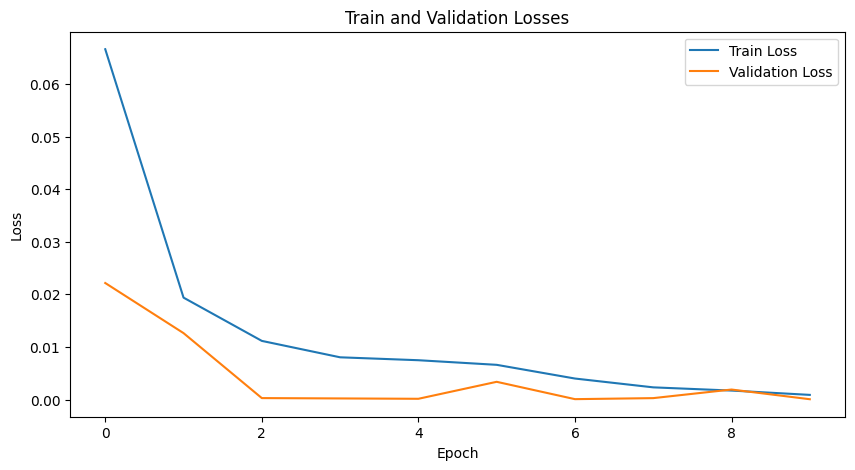

In [168]:
model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2])
#model.load_state_dict(torch.load("./2. Weight/0320_3.pth"))
#model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

In [169]:
model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2])
model.load_state_dict(torch.load("weight/1002_10.pth"))
#model.eval()

/tmp/ipykernel_69783/3609488738.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("weight/1002_10.pth"))


<All keys matched successfully>

In [170]:
#123 폴더 확인

test_123 = pd.read_csv('train_data/test_image_class_info.csv')
test_dataset = CustomDataset(test_123['image_path'].values, None)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [171]:
''' test_dataset = CustomDataset(test['image_path'].values, None)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)''' 

" test_dataset = CustomDataset(test['image_path'].values, None)\ntest_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)"

In [172]:
def inference(model, test_loader, device):
    count = 1
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for images in tqdm(iter(test_loader)):
            images = images.to(device)
            logit = model(images)
            #print(count)
            #print(logit)
            #print()
            count = count + 1
            #print("logit: ",logit)
            
            preds += logit.argmax(1).detach().cpu().numpy().tolist()
            #print("preds: ",preds)

            #print()
            
            
    return preds

In [173]:
%%time
preds = inference(model, test_loader, device)

  0%|          | 0/6750 [00:00<?, ?it/s]

CPU times: user 5min 57s, sys: 564 ms, total: 5min 58s
Wall time: 49.2 s


In [174]:
#print(preds)

test_result = test_123['class']



from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# score = roc_auc_score(test_result, preds)
# score_2 = f1_score(test_result, preds, average='macro')
score_3 = accuracy_score(test_result, preds)

# print(score)
# print(score_2)
print(score_3)

0.9998518518518519


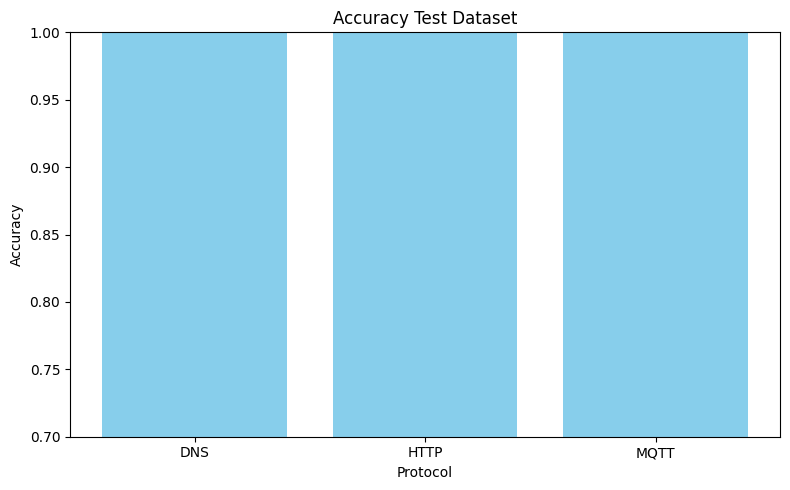

Accuracy for DNS: 100.00%
Accuracy for MQTT: 99.98%
Accuracy for HTTP: 99.98%


In [175]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

preds = np.array(preds)

classes = test_123['class'].unique()

class_accuracy = {}


for class_label in classes:
    class_mask = test_123['class'] == class_label
    class_preds = preds[class_mask] 
    class_result = test_123['class'][class_mask]  

    accuracy = accuracy_score(class_result, class_preds)

    class_accuracy[class_label] = accuracy

target_classes = [0, 1, 2]  # DNS, HTTP, MQTT
class_labels = [label for label in target_classes if label in class_accuracy]
accuracies = [class_accuracy[label] for label in class_labels]

class_names = ['DNS', 'HTTP', 'MQTT']

plt.figure(figsize=(8, 5))
plt.bar(class_names, accuracies, color='skyblue')
plt.xlabel('Protocol')
plt.ylabel('Accuracy')
plt.title('Accuracy Test Dataset')
plt.ylim([0.7, 1])
plt.tight_layout()
plt.show()

for class_label, accuracy in class_accuracy.items():
    if class_label in class_labels:
        print(f'Accuracy for {class_names[class_label]}: {accuracy:.2%}')